<a href="https://colab.research.google.com/github/Malin-C/StockMarket/blob/main/Predicting_Stock_LSTM_%2B_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
# Get the stock quote
df = DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=datetime.now())
# Show data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.650659
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.718646
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.859850
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.994284
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.973674
...,...,...,...,...,...,...
2021-02-04,137.399994,134.589996,136.300003,137.389999,84183100.0,137.184998
2021-02-05,137.419998,135.860001,137.350006,136.759995,75524000.0,136.759995
2021-02-08,136.960007,134.919998,136.029999,136.910004,71297200.0,136.910004


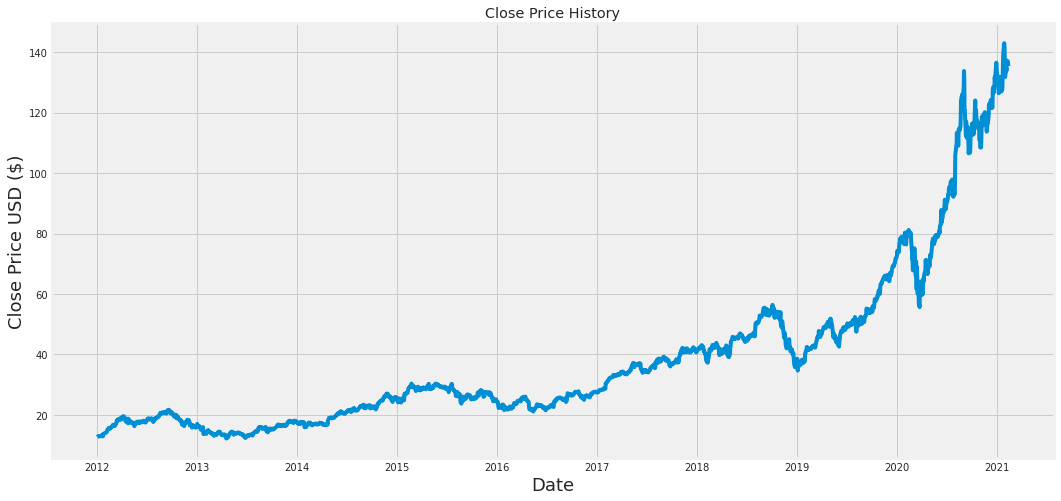

In [3]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [4]:
#Create a new dataframe with only the 'Close column
series = df['Adj Close'].values
time = df.reset_index()['Date'].values
print(len(time), len(series))

split_threshold = 0.8
split_time = int(split_threshold * len(series))
print(split_time)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

2292 2292
1833


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1833,)
Epoch 1/100
7/7 [==============================] - 5s 30ms/step - loss: 45.3126 - mae: 45.8101
Epoch 2/100
7/7 [==============================] - 0s 26ms/step - loss: 44.7768 - mae: 45.2743
Epoch 3/100
7/7 [==============================] - 0s 24ms/step - loss: 43.7937 - mae: 44.2910
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 42.5834 - mae: 43.0806
Epoch 5/100
7/7 [==============================] - 0s 24ms/step - loss: 41.0765 - mae: 41.5737
Epoch 6/100
7/7 [==============================] - 0s 23ms/step - loss: 39.1978 - mae: 39.6949
Epoch 7/100
7/7 [==============================] - 0s 24ms/step - loss: 36.7770 - mae: 37.2738
Epoch 8/100
7/7 [==============================] - 0s 28ms/step - loss: 33.9110 - mae: 34.4081
Epoch 9/100
7/7 [==============================] - 0s 27ms/step - loss: 30.1378 - mae: 30.6359
Epoch 10/100
7/7 [=========================

(1e-08, 0.0001, 0.0, 60.0)

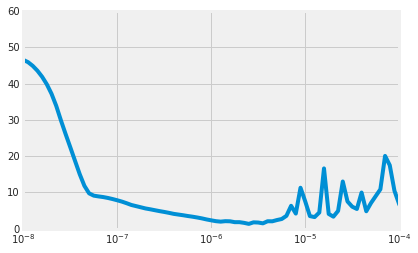

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
18/18 [==============================] - 3s 15ms/step - loss: 19.6669 - mae: 20.1592
Epoch 2/150
18/18 [==============================] - 0s 15ms/step - loss: 3.9273 - mae: 4.4017
Epoch 3/150
18/18 [==============================] - 0s 15ms/step - loss: 1.7851 - mae: 2.2348
Epoch 4/150
18/18 [==============================] - 0s 14ms/step - loss: 1.2669 - mae: 1.6946
Epoch 5/150
18/18 [==============================] - 0s 14ms/step - loss: 1.0430 - mae: 1.4630
Epoch 6/150
18/18 [==============================] - 0s 14ms/step - loss: 0.7834 - mae: 1.1780
Epoch 7/150
18/18 [==============================] - 0s 14ms/step - loss: 0.6883 - mae: 1.0749
Epoch 8/150
18/18 [==============================] - 0s 14ms/step - loss: 0.5566 - mae: 0.9127
Epoch 9/150
18/18 [==============================] - 0s 13ms/step - loss: 0.5538 - mae: 0.9107
Epoch 10/150
18/18 [==============================] - 0s 14ms/step - loss: 0.6273 - mae: 1.0106
Epoch 11/150
18/18 [===========================

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

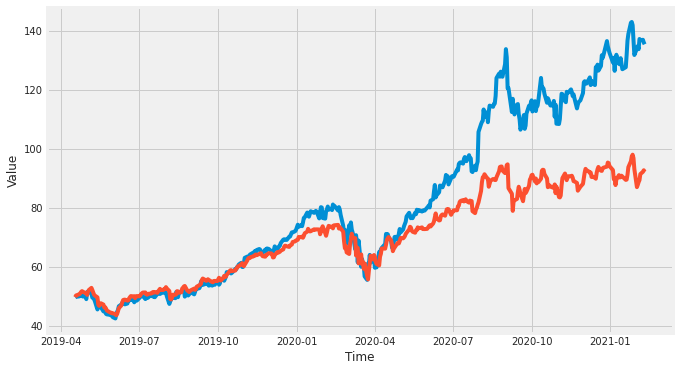

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

11.710018

In [16]:
print(rnn_forecast)

[49.82307  50.381123 50.83206  51.179462 51.608967 51.863934 51.643986
 51.23483  51.168102 50.573944 51.689754 52.237846 52.96253  52.259953
 51.42563  50.68614  50.35566  49.752316 47.278866 46.867035 47.25802
 47.750843 47.310726 46.304207 46.429165 45.969196 45.295612 44.59933
 44.55352  44.341976 44.357716 44.070545 43.67584  44.125687 45.144726
 46.083664 47.057796 48.07033  48.830036 48.93734  48.98651  48.644726
 48.724182 49.401337 49.82675  50.177353 50.072216 50.140892 49.49178
 49.943604 50.18671  50.101143 50.36781  50.885666 51.378178 51.40599
 50.817734 50.623997 50.891518 50.971527 51.03876  51.384197 51.578354
 51.342266 51.560463 51.282948 51.81508  52.227776 52.630764 52.244205
 52.268993 52.54525  52.612858 53.206833 52.762253 51.883995 49.198162
 49.039066 49.491665 50.65312  50.616814 50.78123  51.8409   51.77673
 51.34489  51.459877 52.749886 53.026413 53.460495 53.59307  52.01878
 51.84251  51.556458 51.87877  52.14358  52.714687 52.271606 52.538956
 53.370274 5